MODELO PARA RESPONDER:

1. Modelo 1: Predecir fabricadas
2. Modelo 2: Predecir duración de fabricación

*Generales*

In [1]:
import sys
import os

sys.path.append(os.path.abspath('../package'))
%load_ext autoreload
%autoreload 2

from functions.data_loader import load_excel_data
file = "../../data/BASE DE DATOS PCC_cleaned.xlsx"
df_char = load_excel_data(file)

Archivo cargado correctamente desde ../../data/BASE DE DATOS PCC_cleaned.xlsx


*Preparación de los datos* - Modelo 1

In [6]:

from functions.data_preparation import prepare_regression_data

features = {
    'maquina': 'categorical',
    'seccion': 'categorical',
    'proceso': 'categorical',
    'usuario': 'categorical',
    'duracion_min': 'numeric',
    'hora_inicio': 'numeric',
    'dia_semana_inicio': 'categorical',
    'turno': 'categorical'
}

X_train, X_test, y_train, y_test, encoder, scaler = prepare_regression_data(df_char,features,"fabricadas")

Data prepared: 14608 training samples, 3653 test samples.
Categorical features encoded: ['maquina', 'seccion', 'proceso', 'usuario', 'dia_semana_inicio', 'turno']


In [ ]:
from functions.data_preparation import select_features_lasso
features_lasso = select_features_lasso(X_train, y_train,  X_test=X_test, y_test=y_test)

Lasso coefficients:
maquina               -69.864911
seccion               804.953762
proceso             -2779.942444
usuario                58.558022
duracion_min         9625.588255
hora_inicio          -421.864566
dia_semana_inicio     109.740777
turno                 141.432318
dtype: float64

Selected features by Lasso:
['maquina', 'seccion', 'proceso', 'usuario', 'duracion_min', 'hora_inicio', 'dia_semana_inicio', 'turno']

R² on test set: 0.3775


In [18]:
from functions.data_preparation import select_features_ols
features_ols,_ = select_features_ols(X_train, y_train, p_threshold=0.05)

P-values:
maquina              0.157999
seccion              0.000218
proceso              0.000000
usuario              0.000641
duracion_min         0.000000
hora_inicio          0.004907
dia_semana_inicio    0.096427
turno                0.221406
dtype: float64

Significant features (p <= 0.05):
['seccion', 'proceso', 'usuario', 'duracion_min', 'hora_inicio']


In [16]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [1,3, 5, 7, 9, 11,15,20,25,30,35,40],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
        }
    }
}

In [49]:
from functions.model_evaluation import evaluate_regression_models
# Filter X_train and X_test to keep only features selected by OLS
X_train_selected = X_train[features_ols]
X_test_selected = X_test[features_ols]
tuned_results, summary_metrics, all_grid,best_models = evaluate_regression_models(
    models,
    X_train, y_train,
    X_test=X_test,
    y_test=y_test,
    scoring="neg_root_mean_squared_error",
    cv=5
)

Evaluating: LinearRegression
Best Params                    {}
RMSE CV              19033.897385
MAE CV                11538.06395
R2 CV                    0.387608
RMSE Test            19218.296351
MAE Test             11582.436254
R2 Test                  0.377836
Training Time (s)        2.837198
dtype: object


Evaluating: Lasso
Best Params          {'alpha': 1.0}
RMSE CV                19033.896772
MAE CV                 11537.895746
R2 CV                      0.387608
RMSE Test              19218.387639
MAE Test                11582.28773
R2 Test                     0.37783
Training Time (s)          2.134747
dtype: object


Evaluating: Ridge
Best Params          {'alpha': 10.0}
RMSE CV                 19033.886186
MAE CV                  11536.331397
R2 CV                       0.387608
RMSE Test               19218.195777
MAE Test                 11580.81621
R2 Test                     0.377843
Training Time (s)           0.136488
dtype: object


Evaluating: RandomForest
Best P

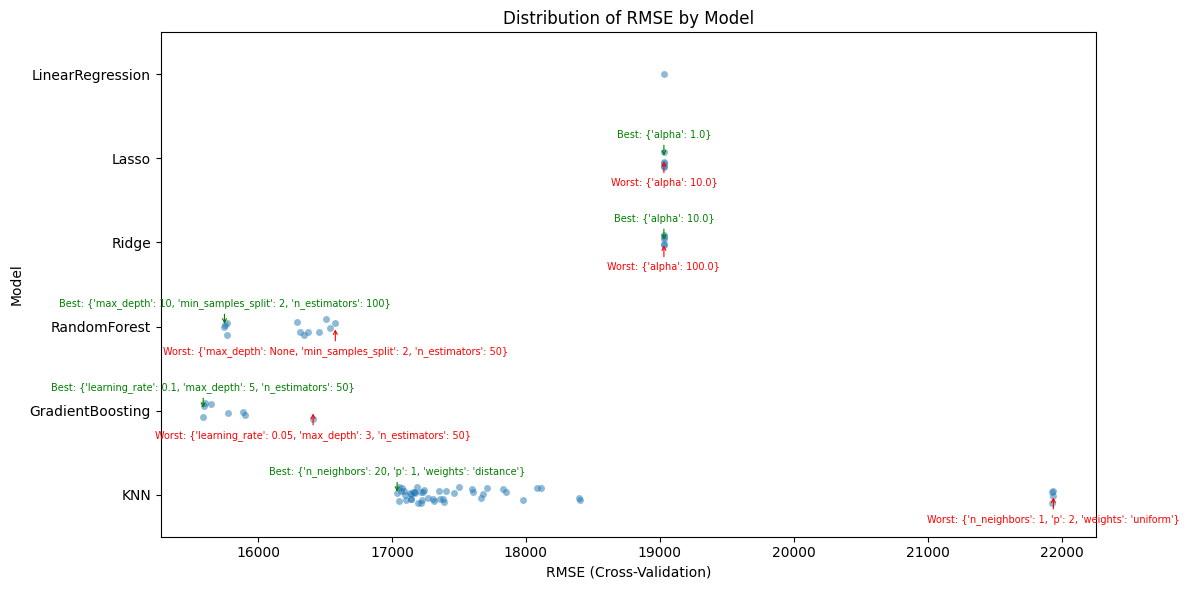

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,...,Model,param_alpha,param_max_depth,param_min_samples_split,param_n_estimators,param_learning_rate,param_n_neighbors,param_p,param_weights,rmse
0,0.006798,0.000399,0.002202,0.000397,{},-19269.825214,-19413.484101,-19131.280849,-18970.078158,-18367.296613,...,LinearRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19030.392987
1,0.007400,0.000488,0.002400,0.001202,{'alpha': 0.001},-19269.825234,-19413.484211,-19131.280797,-18970.078051,-18367.296638,...,Lasso,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19030.392986
2,0.008602,0.001356,0.002802,0.000748,{'alpha': 0.01},-19269.825409,-19413.485206,-19131.280324,-18970.077081,-18367.296857,...,Lasso,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19030.392975
3,0.008209,0.000751,0.002803,0.000406,{'alpha': 0.1},-19269.827166,-19413.495140,-19131.275605,-18970.067387,-18367.299061,...,Lasso,0.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19030.392872
4,0.007310,0.000601,0.002805,0.000748,{'alpha': 1.0},-19269.844928,-19413.594710,-19131.228595,-18969.970644,-18367.321285,...,Lasso,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19030.392032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.027303,0.001592,0.141984,0.014851,"{'n_neighbors': 35, 'p': 2, 'weights': 'distan...",-17577.380728,-17669.354860,-17265.414513,-17353.986079,-16666.308021,...,KNN,NaN,NaN,NaN,NaN,NaN,35.0,2.0,distance,17306.488840
75,0.035106,0.012217,0.207534,0.050218,"{'n_neighbors': 40, 'p': 1, 'weights': 'uniform'}",-18262.081273,-18194.830102,-17874.588481,-17723.327601,-17088.971485,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,1.0,uniform,17828.759788
76,0.026412,0.000971,0.191221,0.032511,"{'n_neighbors': 40, 'p': 1, 'weights': 'distan...",-17535.396302,-17702.745713,-17204.772826,-17229.480131,-16542.395896,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,1.0,distance,17242.958174
77,0.028300,0.002131,0.137299,0.018050,"{'n_neighbors': 40, 'p': 2, 'weights': 'uniform'}",-18379.201120,-18329.457767,-17984.298965,-17956.408903,-17224.506869,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,2.0,uniform,17974.774725


In [36]:
from functions.plotter import plot_cv_metric_distribution
plot_cv_metric_distribution([all_grid], metric_name="rmse", maximize=False)

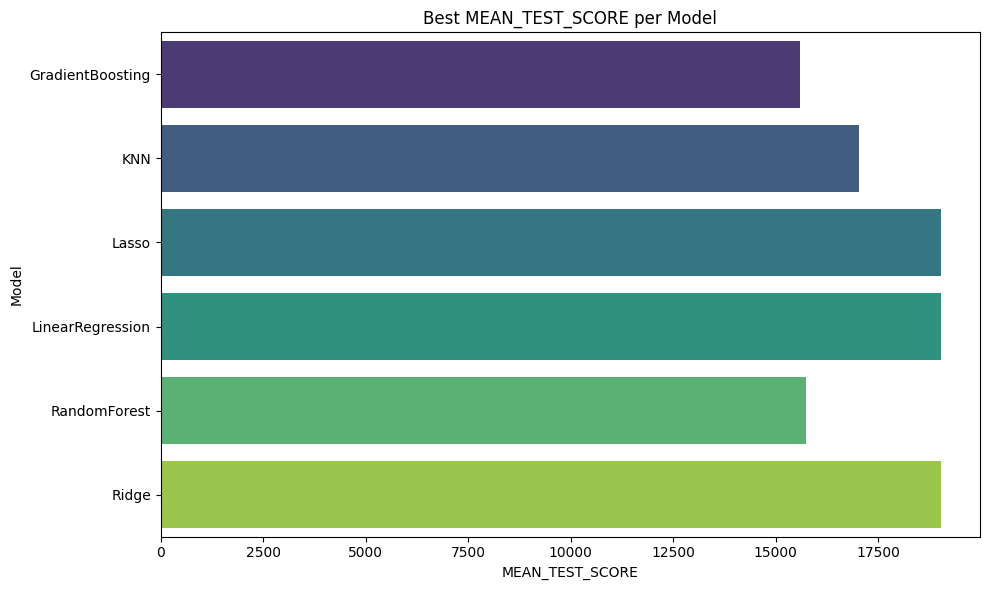

In [48]:
from functions.plotter import plot_best_metric_per_model
best_rmse_df = plot_best_metric_per_model([all_grid], metric='mean_test_score', maximize=False)